In [36]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [37]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

## Load the dataset


In [38]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    )

Found 2152 files belonging to 3 classes.


In [39]:
classnames = dataset.class_names
classnames

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [40]:
len(dataset)

68

In [41]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 0 2 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 0 1]


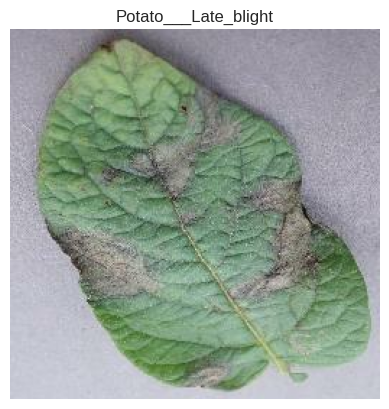

In [42]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(classnames[label_batch[0]])

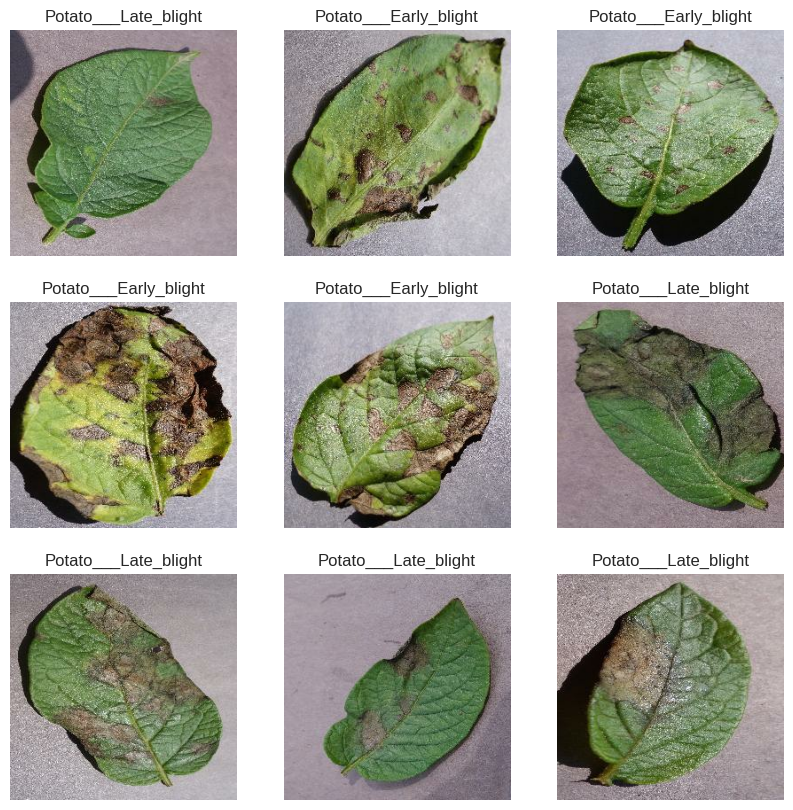

In [43]:
for image_batch, label_batch in dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classnames[label_batch[i]])
        plt.axis("off")
    plt.show()

In [44]:
train_size = 0.8
val_size = 0.1
test_size = 0.1
len(dataset) * train_size

54.400000000000006

In [45]:
train_ds = dataset.take(int(len(dataset) * train_size))
test_ds = dataset.skip(int(len(dataset) * train_size))   

In [46]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [47]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [48]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

## Preprocessing the dataset

In [49]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [50]:
data_argmentation = tf.keras.Sequential([
    # pre-processing pipeline
    layers.experimental.preprocessing.Rescaling(1.0/255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

## Training the Model

In [51]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(classnames)

model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),    
    # Dense Layers
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5), # <<< INCREASED from 0.3 to 0.5
    
    # Output Layer
    layers.Dense(n_classes, activation='softmax'),
])

model.build((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [52]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 64)       

In [53]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [54]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping],
)

Epoch 1/50
54/54 [==============================] - 34s 604ms/step - loss: 1.0955 - accuracy: 0.5075 - val_loss: 0.7869 - val_accuracy: 0.6302
Epoch 2/50
54/54 [==============================] - 31s 568ms/step - loss: 0.7990 - accuracy: 0.6105 - val_loss: 0.5326 - val_accuracy: 0.8281
Epoch 3/50
54/54 [==============================] - 31s 582ms/step - loss: 0.7326 - accuracy: 0.6429 - val_loss: 0.6838 - val_accuracy: 0.6875
Epoch 4/50
54/54 [==============================] - 32s 585ms/step - loss: 0.5674 - accuracy: 0.7512 - val_loss: 0.4577 - val_accuracy: 0.8073
Epoch 5/50
54/54 [==============================] - 32s 593ms/step - loss: 0.4252 - accuracy: 0.8345 - val_loss: 0.5996 - val_accuracy: 0.8646
Epoch 6/50
54/54 [==============================] - 32s 599ms/step - loss: 0.3162 - accuracy: 0.8895 - val_loss: 0.5089 - val_accuracy: 0.7552
Epoch 7/50
54/54 [==============================] - 32s 599ms/step - loss: 0.2401 - accuracy: 0.9207 - val_loss: 0.2256 - val_accuracy: 0.8906

In [55]:
scores = model.evaluate(test_ds, verbose=1)

8/8 [==============================] - 2s 133ms/step - loss: 0.0089 - accuracy: 0.9961


In [56]:
scores

[0.008885696530342102, 0.99609375]

In [57]:
history

In [58]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [59]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']  

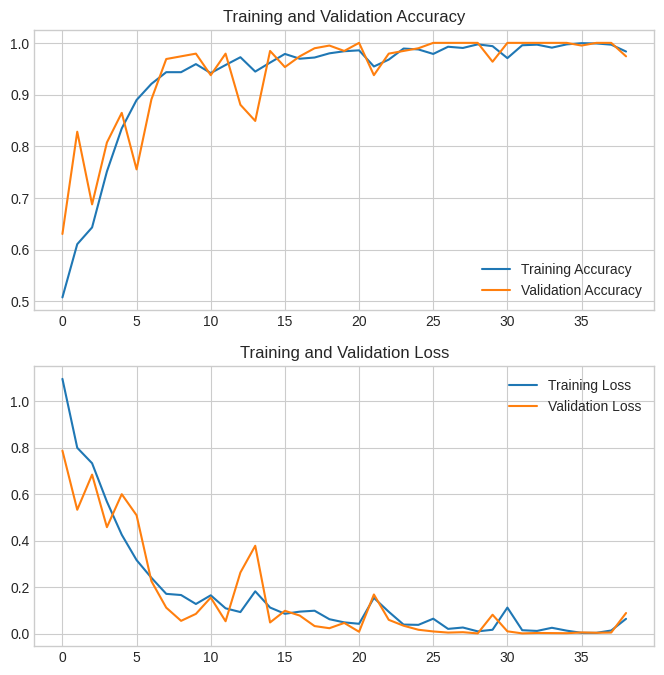

In [60]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()  

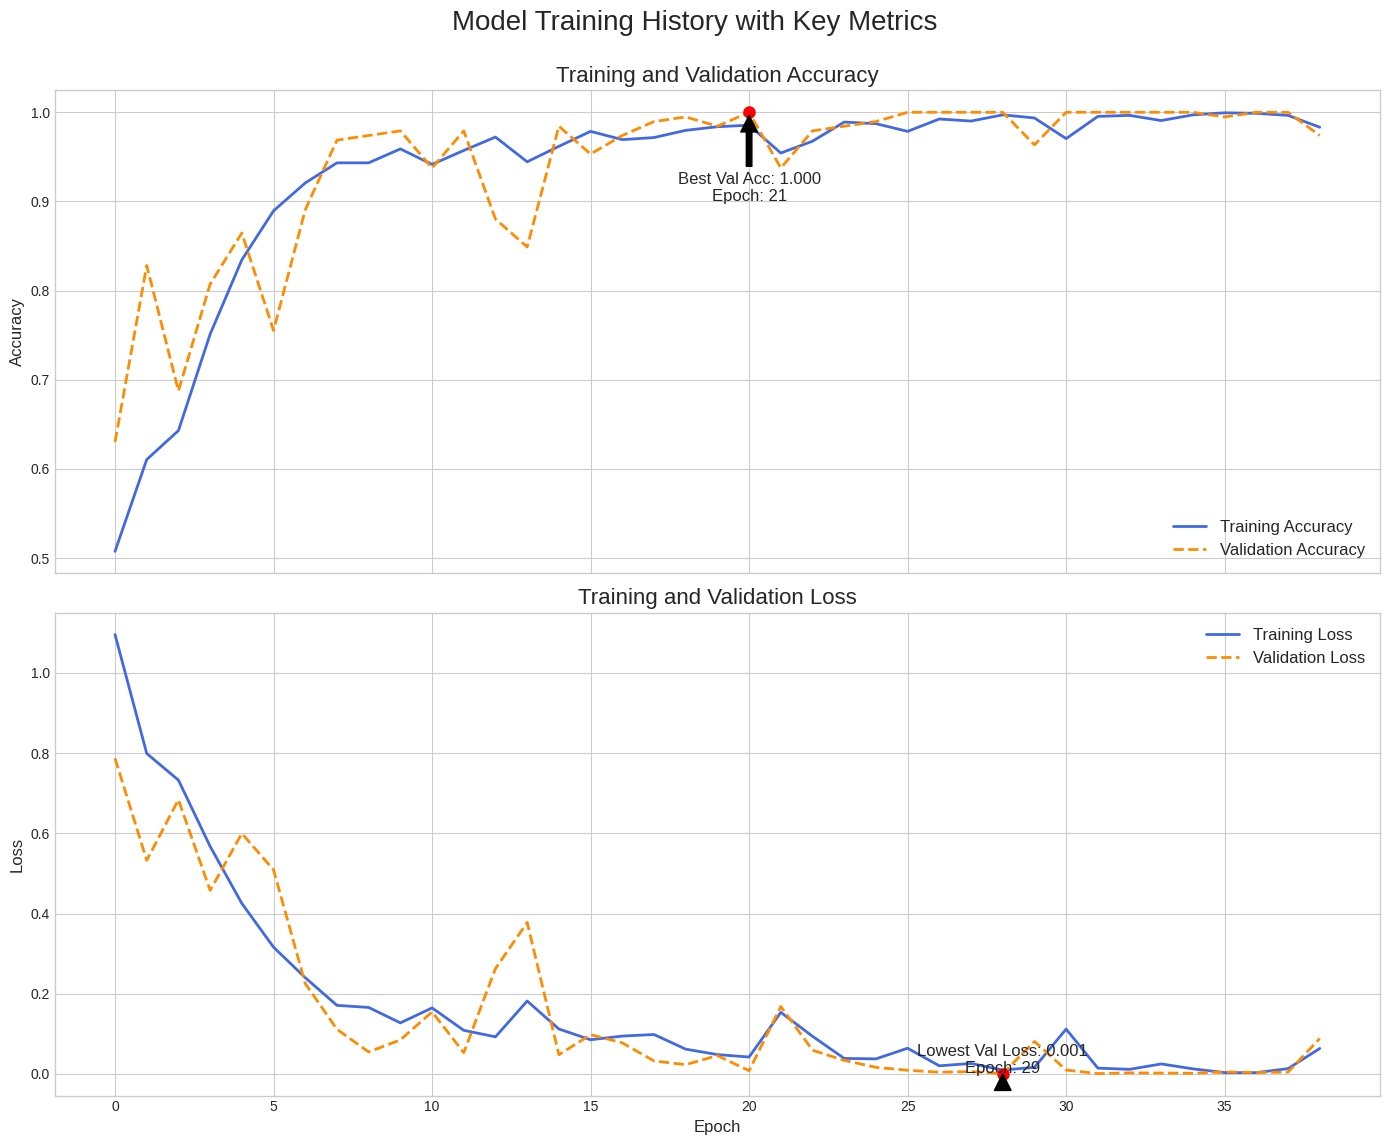

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting the history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(accuracy))

# Use a professional plot style
plt.style.use('seaborn-v0_8-whitegrid')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# --- Plot 1: Training and Validation Accuracy ---
ax1.plot(epochs_range, accuracy, label='Training Accuracy', color='royalblue', linewidth=2)
ax1.plot(epochs_range, val_accuracy, label='Validation Accuracy', color='darkorange', linestyle='--', linewidth=2)
ax1.legend(loc='lower right', fontsize=12)
ax1.set_title('Training and Validation Accuracy', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=12)

# Find and annotate the best validation accuracy
best_epoch_acc = np.argmax(val_accuracy)
best_val_acc = val_accuracy[best_epoch_acc]
ax1.annotate(f'Best Val Acc: {best_val_acc:.3f}\nEpoch: {best_epoch_acc+1}',
             xy=(best_epoch_acc, best_val_acc),
             xytext=(best_epoch_acc, best_val_acc * 0.9),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, ha='center')
ax1.plot(best_epoch_acc, best_val_acc, 'o', color='red', markersize=8, label='Best Val Accuracy')


# --- Plot 2: Training and Validation Loss ---
ax2.plot(epochs_range, loss, label='Training Loss', color='royalblue', linewidth=2)
ax2.plot(epochs_range, val_loss, label='Validation Loss', color='darkorange', linestyle='--', linewidth=2)
ax2.legend(loc='upper right', fontsize=12)
ax2.set_title('Training and Validation Loss', fontsize=16)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_xlabel('Epoch', fontsize=12)

# Find and annotate the lowest validation loss
best_epoch_loss = np.argmin(val_loss)
best_val_loss = val_loss[best_epoch_loss]
ax2.annotate(f'Lowest Val Loss: {best_val_loss:.3f}\nEpoch: {best_epoch_loss+1}',
             xy=(best_epoch_loss, best_val_loss),
             xytext=(best_epoch_loss, best_val_loss * 1.5),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=12, ha='center')
ax2.plot(best_epoch_loss, best_val_loss, 'o', color='red', markersize=8, label='Lowest Val Loss')


# Add a main title to the figure
plt.suptitle('Model Training History with Key Metrics', fontsize=20, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to make room for suptitle
plt.show()

First image label: Potato___healthy
Predicted label: Potato___healthy


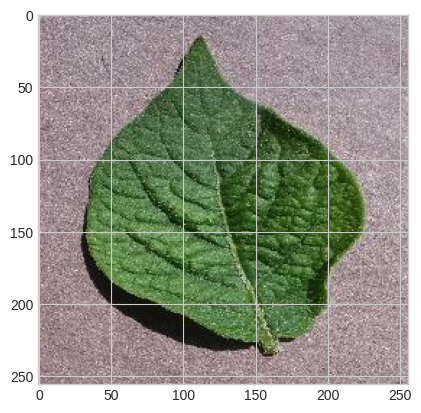

In [67]:
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()

    print(f"First image label: {classnames[first_label]}")
    plt.imshow(first_image)

    batch_prediction = model.predict(image_batch)
    print(f"Predicted label: {classnames[batch_prediction[0].argmax()]}")


In [68]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)
    score_array = predictions[0]

    predicted_label = classnames[predictions[0].argmax()]
    condifidence = round(100* predictions[0].max(), 2)

    all_percentages = {classnames[i]: round(100 * score_array[i], 2) for i in range(len(classnames))}

    return predicted_label, condifidence, all_percentages

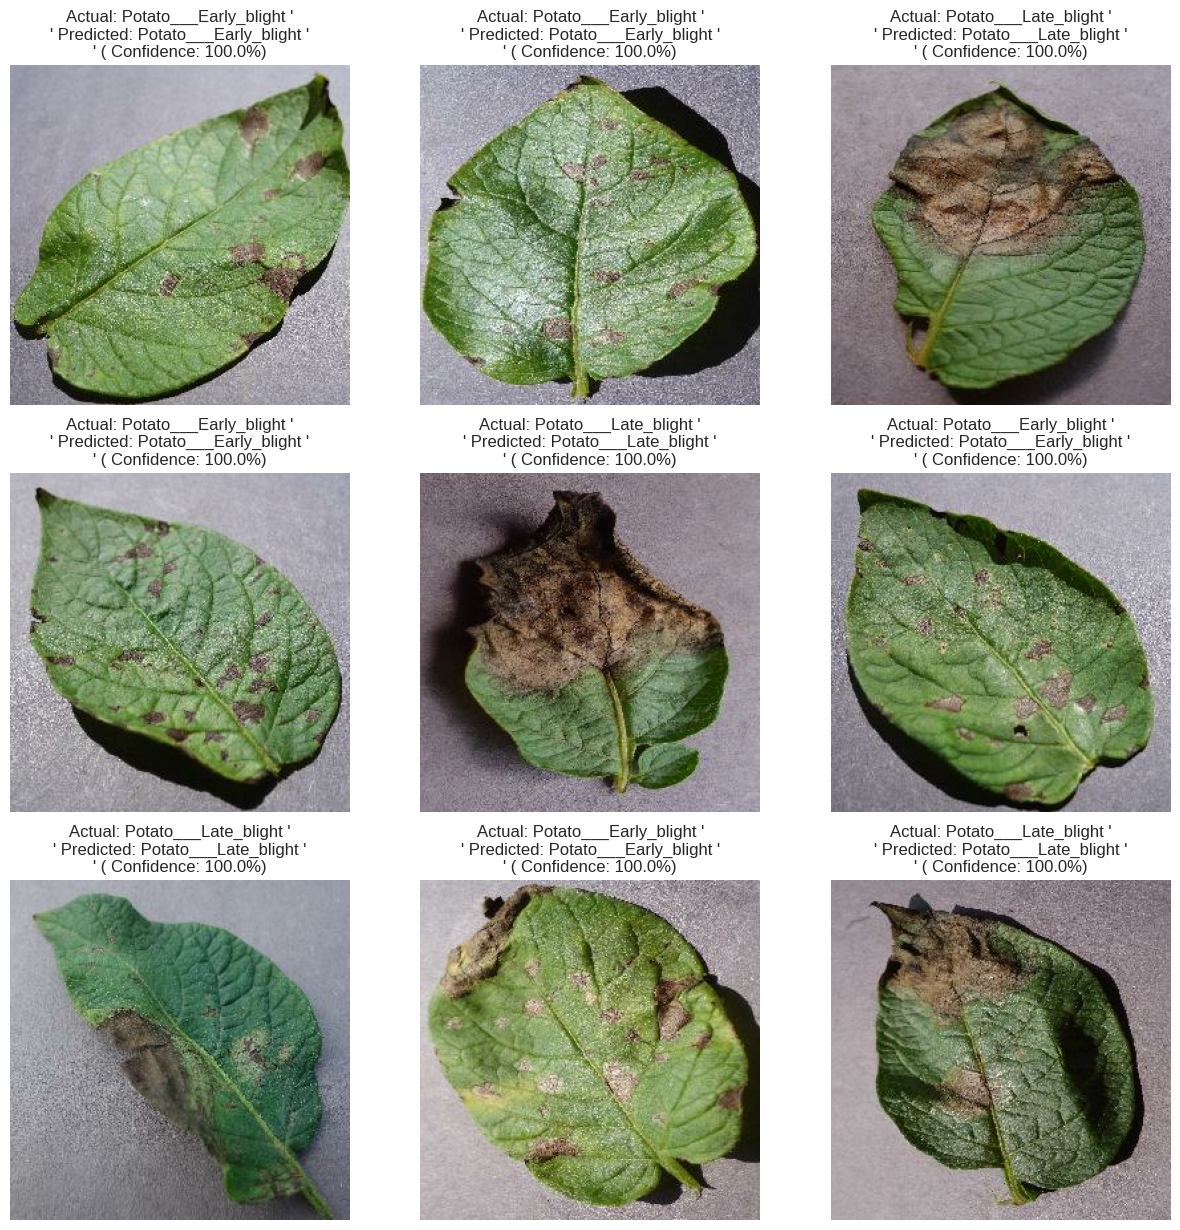

In [69]:
plt.figure(figsize=(15, 15))
for image_batch, label_batch in test_ds.take(1):
    for i in range(min(9, len(image_batch))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))

        predicted_label, confidence, _ = predict(model, image_batch[i].numpy())
        actual_label = classnames[label_batch[i].numpy()]
        plt.title(f"Actual: {actual_label} '\n' Predicted: {predicted_label} '\n' ( Confidence: {confidence}%)")
        plt.axis("off")
    plt.show()

Classification Report:
                        precision    recall  f1-score   support

Potato___Early_blight       1.00      0.99      1.00       129
 Potato___Late_blight       0.99      1.00      1.00       116
     Potato___healthy       1.00      1.00      1.00        11

             accuracy                           1.00       256
            macro avg       1.00      1.00      1.00       256
         weighted avg       1.00      1.00      1.00       256



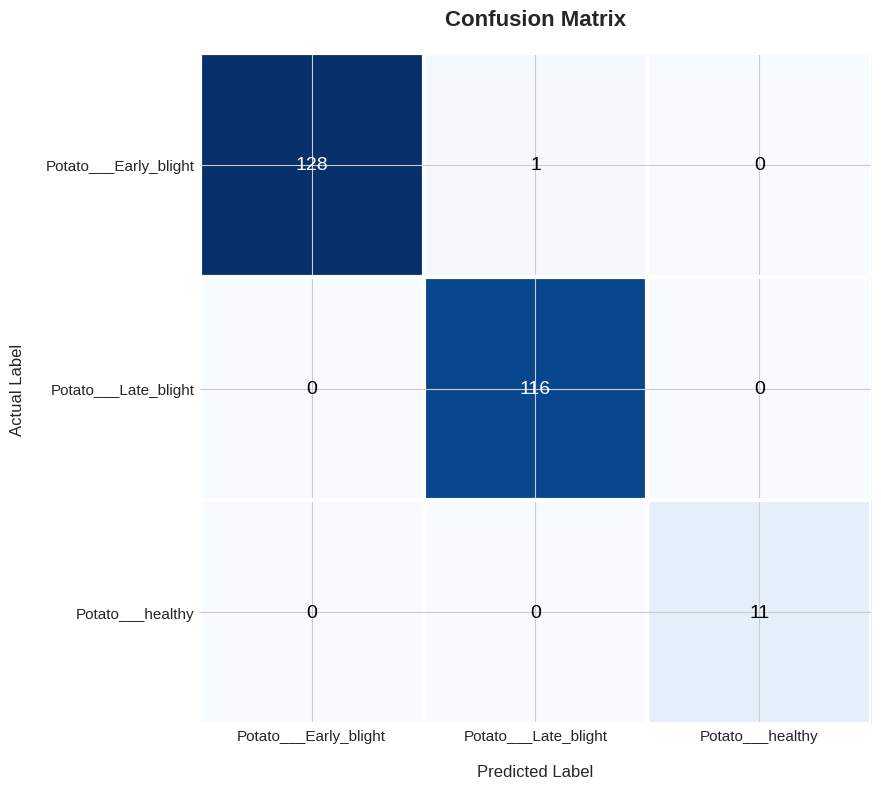

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# --- This part remains the same ---
# Get all labels and predictions from the test set
y_true = []
y_pred = []

# Loop through the entire test dataset
for image_batch, label_batch in test_ds:
    y_true.extend(label_batch.numpy())
    preds = model.predict(image_batch, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

# --- This part remains the same ---
# Generate and print the reports
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classnames))

# --- MODIFICATION: A much nicer plot using only Matplotlib ---
cm = confusion_matrix(y_true, y_pred)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, cmap='Blues')

# --- Style Improvements ---
# Hide the outer box (spines)
for edge, spine in ax.spines.items():
    spine.set_visible(False)

# Add clear gridlines to separate the cells (seaborn-style)
ax.set_xticks(np.arange(cm.shape[1]+1)-.5, minor=True)
ax.set_yticks(np.arange(cm.shape[0]+1)-.5, minor=True)
ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
ax.tick_params(which="minor", bottom=False, left=False)

# Remove the small tick marks on the axes
ax.tick_params(top=False, bottom=False, left=False, right=False)


# --- Labels and Annotations ---
# Set titles and labels with better font sizes
ax.set_title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Predicted Label', fontsize=12, labelpad=15)
ax.set_ylabel('Actual Label', fontsize=12, labelpad=15)

# Set the tick labels to be the class names
ax.set_xticks(np.arange(cm.shape[1]))
ax.set_yticks(np.arange(cm.shape[0]))
ax.set_xticklabels(classnames, fontsize=11)
ax.set_yticklabels(classnames, fontsize=11)

# Loop over data dimensions and create text annotations for each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                fontsize=14,
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()

In [71]:
model_version = 5

model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/5/assets
